**摇臂实验**
    @author: piperliu@qq.com
    @github: [PiperLiu/Reinforcement-Learning-practice-zh](https://github.com/PiperLiu/Reinforcement-Learning-practice-zh)
    @csdn: [piperliu@qq.com的博客](https://blog.csdn.net/weixin_42815609)

founded in 2019-12-10

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### 产生摇臂

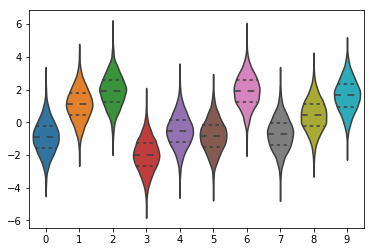

In [2]:
# 10个摇臂的编号，从0开始
K = np.array(range(10))
# 摇臂的奖赏：sigma为1的正态分布，mu不同，下面是生成mu的
R_mu = np.array([np.random.uniform(-2,2) for i in range(10)])
def K_Reward(R_mu_):
    return np.random.normal(loc=R_mu_, scale=1.0)

# 产生5000个样本，查看摇臂图像
demoData = np.array([
    [K_Reward(R_mu[i]) for i in range(R_mu.shape[0])]
    for j in range(5000)])
sns.violinplot(data=demoData, inner="quartile")
del demoData

### epsilon-贪心算法

使用增量式计算的样本均值作为指标，公式为，对于每一个动作，有：

$$Q_n = \frac{R_1+R_2+...+R_{n-1}}{n-1}$$

程序实现时，使用上述方法计算该指标，$R_{n}$表示这一动作第n次执行时获得的收益。每个动作执行的次数记录在字典count中，实际上较为浪费空间，可以简化为：

$$Q_{n+1} = Q_n + \frac{1}{n} \left[ R_n - Q_n \right]$$

推导较为简单，略。

In [3]:
def greed_epsilon(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    
    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k] * count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i + 1))
    
    return array

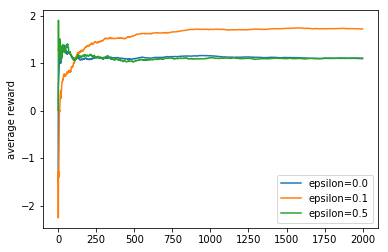

In [4]:
# excute and plot
t = 2000
T = np.arange(t)
demo_0dot0 = greed_epsilon(R_mu, t, epsilon=0.0)
demo_0dot1 = greed_epsilon(R_mu, t, epsilon=0.1)
demo_0dot5 = greed_epsilon(R_mu, t, epsilon=0.5)

plt.plot(T, demo_0dot0)
plt.plot(T, demo_0dot1)
plt.plot(T, demo_0dot5)
plt.legend(("epsilon=0.0", "epsilon=0.1", "epsilon=0.5"))
plt.ylabel("average reward")
plt.show()

如上图，可以注意到，在迭代次数500后，epsilon=0.1的贪心算法效果几乎总比其他两个好。
原因可能有：
- 比0.0好是因为0.1不陷入局部最优解，总有跳出去“探索exploration”的可能；
- 比0.5好是因为0.1能有效利用现有信息，选择较好的摇臂。

在信息完全的情况下，我们知道，2000步中每次都应该选择R_mu值最高的摇臂，这样在大样本情况下平均收益才是最高的。**如果算法足够聪明的话，它应该在多次迭代后能判断出谁是最优动作，并且总是做出最优动作。**下面测试最优动作。

In [5]:
def greed_epsilon_return_action(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    
    optimal_actions = [0]
    # 找到最优动作
    optimalAction = np.argmax(R_mu)
    
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))

    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k] * count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i + 1))
        
        if k == optimalAction:
            optimal_actions.append((optimal_actions[-1] * i + 1) / (i + 1))
        else:
            optimal_actions.append(optimal_actions[-1] * i / (i + 1))
    
    optimal_actions.pop(-1)
    
    return (array, optimal_actions)

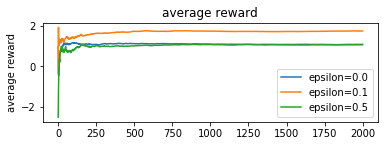

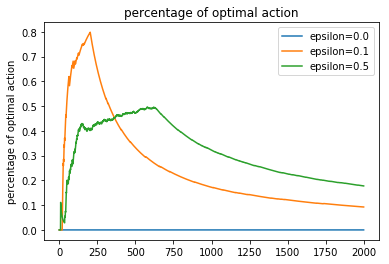

In [6]:
# excute and plot
t = 2000
T = np.arange(t)
demo_0dot0 = greed_epsilon_return_action(R_mu, t, epsilon=0.0)
demo_0dot1 = greed_epsilon_return_action(R_mu, t, epsilon=0.1)
demo_0dot5 = greed_epsilon_return_action(R_mu, t, epsilon=0.5)

fig = plt.figure()
fig.add_subplot(211)
plt.title("average reward")
plt.plot(T, demo_0dot0[0])
plt.plot(T, demo_0dot1[0])
plt.plot(T, demo_0dot5[0])
plt.legend(("epsilon=0.0", "epsilon=0.1", "epsilon=0.5"))
plt.ylabel("average reward")
plt.show()
fig.add_subplot(212)
plt.title("percentage of optimal action")
plt.plot(T, demo_0dot0[1])
plt.plot(T, demo_0dot1[1])
plt.plot(T, demo_0dot5[1])
plt.legend(("epsilon=0.0", "epsilon=0.1", "epsilon=0.5"))
plt.ylabel("percentage of optimal action")
plt.show()

如上图，应该注意：
- 这里的贪心算法并不会把所有摇臂都遍历一遍；
- 因此epsilon=0.0的情况要么最优（k=optimal摇臂，并且一开始为正值），要么很差（陷入局部最优）。

### 非平稳问题

$$Q_{n+1} = Q_n + \frac{1}{n} \left[ R_n - Q_n \right]$$

观察上式，可以看出，权重$\frac{1}{n}$在逐渐减小。对于一个平稳序列而言，这是必要的，因为$\frac{1}{n}$满足下列条件：

$$\sum^{\infty}_{n=1} \alpha_n (a) = \infty \text{ and } \sum^{\infty}_{n=1} \alpha^2_n (a) < \infty$$

即，有足够大的步长能克服任何初始条件及随机波动，并且最终步长能变小，保证收敛。

**但是，非平稳序列不适合上述规律。**因此提出固定步长的更新规则：

$$Q_{n+1} = Q_{n} + \alpha \left[ R_n - Q_n \right]$$

其中，步长$\alpha \in (0,1]$是一个常数，上式可以推导为“指数近因加权平均”的形式：

$$Q_{n+1} = (1-\alpha )^n Q_1 + \sum^n_{i=1} \alpha (1-\alpha )^{n-i} R_i$$

可见，越是新的收益，其对评价指标影响就越大。

尽管强化学习应用在平稳序列的场景中较多，业界还是倾向于使用固定步长而非$\frac{1}{n}$。

### 乐观初始值

上例中，每台摇臂的初始值都设为$Q_1 (a) = 0$。如果将每台摇臂的初始值都设为$Q_1 (a) = 5$，则贪心算法会去尝试每台摇臂。原因：每台摇臂的一次奖励一般不会达到5之高。因此，在开始时，测试任意一台摇臂，机器都会感到“失望”，转向下一个没用过的摇臂。

如此，鼓励了机器对每台摇臂进行测试，这种鼓励试探的技术叫作“乐观初始值”。

下面是代码测试：
- 以最优动作占比为评价指标；
- 采用恒定步长参数；
- epsilon=0.1 & 不使用乐观初始值作对比。

In [7]:
def greed_epsilon_encourage_exploration(R_mu, t, epsilon, q):
    
    optimal_actions = [0]
    # 找到最优动作
    optimalAction = np.argmax(R_mu)
    
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [q] * R_mu.shape[0]))

    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        Q[k] = Q[k] + 0.1 * (reward_current - Q[k])
        
        if k == optimalAction:
            optimal_actions.append((optimal_actions[-1] * i + 1) / (i + 1))
        else:
            optimal_actions.append(optimal_actions[-1] * i / (i + 1))
    
    optimal_actions.pop(-1)
    
    return optimal_actions

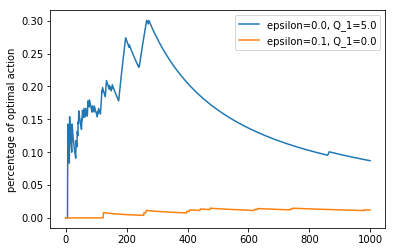

In [8]:
# excute and plot
t = 1000
T = np.arange(t)
demo_0dot0 = greed_epsilon_encourage_exploration(R_mu, t, epsilon=0.0, q=5)
demo_0dot1 = greed_epsilon_encourage_exploration(R_mu, t, epsilon=0.1, q=0)

plt.plot(T, demo_0dot0)
plt.plot(T, demo_0dot1)
plt.legend(("epsilon=0.0, Q_1=5.0", "epsilon=0.1, Q_1=0.0"))
plt.ylabel("percentage of optimal action")
plt.show()

### 修正步长

如果采样不平均，可以用修正步长：

$$\beta_n = \frac{\alpha}{\overline{o}_n}$$

其中，$\overline{o}_n = \overline{o}_{n-1} + \alpha (1 - \overline{o}_{n-1})$，并且$\overline{o}_{0} = 0$。此时，可证$Q_n$是对初始值无偏的指数近因加权平均。

### 基于置信度上界的动作选择（UCB）

基于置信度上界（upper confidence bound, UCB）的动作思想是，基于潜力选择动作。如果一个动作被做过的次数较少，则认为其潜力较大，公式：

$$A_t = \mathop{\arg \max}_{a} \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t (a)}} \right]$$

其中，c是大于0的数，决定置信水平。$N_t(a)$是t时刻前动作a被选择的次数。如果$N_t(a)=0$，则a就被认为是满足最大化条件的动作。可以看出，有关系：

$$t = \sum_a N_t (a)$$

下面是代码测试，评价指标为平均收益，对照组为：
- 参数不同的c；
- epsilon-贪心算法。

In [9]:
def greed_epsilon(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    
    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k] * count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i + 1))
    
    return array

def ucb_c(R_mu, t, c):
    reward = 0
    array = []
    N_list = list(range(R_mu.shape[0]))
    Q_list = list(range(R_mu.shape[0]))
    
    for i in range(t):
        
        try:
            Action = N_list.index(0)
        except ValueError:
            t = sum(N_list)
            polynomial = [Q_list[a] + c * (np.log(t) / N_list[a]) ** 0.5
                             for a in range(R_mu.shape[0])]
            Action = np.argmax(polynomial)
        
        reward_current = K_Reward(R_mu_=R_mu[Action])
        reward += reward_current
        Q_list[Action] = (Q_list[Action] * N_list[Action] + reward_current) / (N_list[Action] + 1)
        N_list[Action] = N_list[Action] + 1
        array.append(reward / (i + 1))
    
    return array

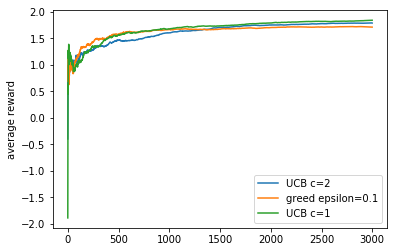

In [10]:
# excute and plot
t = 3000
T = np.arange(t)
demo_ucb_2 = ucb_c(R_mu, t, c=2)
demo_0dot1 = greed_epsilon(R_mu, t, epsilon=0.1)
demo_ucb_1 = ucb_c(R_mu, t, c=1)

plt.plot(T, demo_ucb_2)
plt.plot(T, demo_0dot1)
plt.plot(T, demo_ucb_1)
plt.legend(("UCB c=2", "greed epsilon=0.1", "UCB c=1"))
plt.ylabel("average reward")
plt.show()

如上，与书上不同，ucb确实有优势，但是优势体现在2000次（甚至更多）迭代后，greed平稳，而ucb的指标仍处于上升趋势。

### 梯度赌博机算法

